## Backtesting
### Rendimiento de Carteras con Entradas y Salidas de Efectivo

Este cuaderno muestra cómo realizar la evaluación de carteras de inversión abiertas,
en las que pueden ocurrir entradas y salidas de capital invertido.

Aunque muchos de los algoritmos de trading se evaluan sobre un capital inicial,
en la realidad las entradas y salidas de capital invertido es una situación 
muy habitual, por ejemplo como sucede con los fondos de inversión abiertos

___

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

____
### Datos

In [2]:
ticker_list = ['BBVA','SAN','REP','TEF','IBE','FER','ITX','ACS','AMS','GRF']

In [3]:
import pickle
with open('../data/stock_data.pkl', 'rb') as handle:
    stock_data = pickle.load(handle)

In [4]:
close_series = {ticker: df.close
                for ticker, df in stock_data.items()
                if ticker in ticker_list
               }
stock_df = pd.DataFrame(close_series)
stock_df = stock_df.loc['2016':]

In [5]:
stock_df.head()

,SAN,FER,ACS,AMS,ITX,BBVA,IBE,REP,GRF,TEF
2016-01-04,3.611336,17.329551,20.205989,36.609084,27.617815,5.100387,4.891871,6.709067,19.346262,7.848238
2016-01-05,3.580238,17.375649,20.245065,36.779467,27.428193,5.134364,4.952126,6.649696,19.662386,7.888586
2016-01-06,3.464938,17.283368,20.088595,36.871566,27.252077,5.024630,4.927752,6.459613,19.383973,7.831654
2016-01-07,3.393821,16.960254,19.533020,35.955089,27.157266,4.960496,4.923916,6.203524,19.327359,7.771504
2016-01-08,3.302227,16.834424,19.227764,35.434637,26.773459,4.848485,4.899542,5.954754,19.157518,7.584868


___

### Rentabilidad Ponderada por Tiempo
- En inglés *Time-Weighted Return* (TWR) 
- Es el estándar de la indusria para medir rendimiento cuando hay flujos de caja externos al capital invertido inicialmente
- Equivale al rendimiento que tendría 1€ a lo largo de todo el periodo evaluado, independientemente del dinero que entra y sale

#### Procedimiento de Calculo
El principio básico es componer la rentabilidad de cada unidad de tiempo (ej. días). Sin embargo es suficiente
subdividir en periodos en los que no haya flujos de caja externo. El procedimiento consiste en los siguientes pasos:
1. Se subdivide el período analizado en subperiodos, haciendo un corte siempre que haya un flujo de caja
2. Se calcula la rentabilidad de cada subperiodo considerando la valoración sobre el capital invertido en dicho subperiodo
3. Componer la rentabilidad de cada subperiodo

$$ \rm{TWR} = \prod_{i=1}^n (1 + HPR_i) - 1 $$

donde
- TWR: Time-weighted return
- HPR_i: *Holding-period return*, la rentabilidad de cada sub-periodo $\frac{P_f}{P_i} - 1$ 

____

#### Ejemplo TWR

- Iniciamos una cartera con 100mil euros a principios de año
- El 1 de junio la cartera vale 105mil euros y recibimos una inversión adicional de 20mil
- El 1 de agosto la cartera vale 95 y se sacan 35mil euros
- El 31 de diciembre la cartera vale 90 mil.

Calculamos en miles. Tenemos 3 periodos:
1. $\rm{HPR_1} = \frac{105 - 100}{100} = 0.05$  
Para el siguiente periodo la inversión es $105+20=125$ 

2. $\rm{HPR_2} = \frac{95 - 125}{125} = -0,24$  
Para el siguiente periodo la inversión es $95-35=60$

3. $\rm{HPR_3} = \frac{90 - 60}{60} = 0.50$  


La rentabilidad ponderada por tiempo es:

$ \rm{TWR} = (1.05)(0.76)(1.5) - 1 = 0.197 $

____

#### TWR con valoracion de participaciones
Una forma equivalente de calcular el TWR es asumir que las inversiones corresponden a un **número participaciones** 
que deben tener los mismos beneficios a lo largo del tiempo. (Recordad que el TWR equivale a la rentabilidad de 1€ invertido con independencia de entradas y salidas).  Esto implica que entradas y salidas de capital corresponden con compras y ventas de participaciones al valor liquidativo del día del flujo de entrada/salida.

Este es el mecanismo que utilizan los fondos de inversión abiertos.
- Las entradas corresponden a suscripciones de nuevas participaciones
- Las salidas corresponden a reembolsos de participaciones

El procedimiento consiste en:
1. Calcular el valor liquidativo de una participación. Esto es patrimonio entre número de participaciones
2. Suscripciones y reembolsos se compran o venden a valor liquidativo
3. La rentabilidad se calcula sobre el valor liquidativo

___

#### Ejemplo con valoración de participaciones

Usamos el mismo escenario del ejemplo anterior y partimos de unas 1000 participaciones
valoradas inicialmente a 100€. 

1. El 1 de junio la cartera vale 105mil euros y recibimos una inversión adicional de 20mil
  - valor liquidativo $\rm{VL} = \frac{105000}{1000} = 105$
  - suscripción de $\frac{20000}{105} = 190.47619$ nuevas participaciones
  - total de participaciones 1190.47619

2. El 1 de agosto la cartera vale 95 y se sacan 35mil eurosm
  - valor liquidativo $\rm{VL} = \frac{95000}{1190.47619} = 79.8$
  - reembolso de $\frac{35000}{79.8} = 438.59649$ participaciones
  - total de participaciones $1190.47619 - 438.59649 = 751.8797$

3. El 31 de diciembre la cartera vale 90 mil.
  - valor liquidativo $\rm{VL}= \frac{90000}{751.8797} = 119.7$
  - Rentabilidad de la cartera $ \rm{TWR} = \frac{119.7}{100} - 1 = 0.197$

El resultado, tal como esperábamos es el mismo.

___

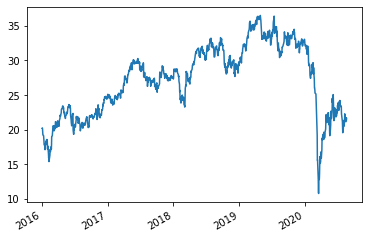

In [6]:
ticker = 'ACS'
stock_series = stock_df[ticker]
stock_series.plot()

In [7]:
# inversion inicial
capital = 100_000

In [8]:
# valor liquidativo, inicial=100
nav = pd.Series(100, index=stock_series.index)
nav

2016-01-04    100
2016-01-05    100
2016-01-06    100
2016-01-07    100
2016-01-08    100
             ... 
2020-08-17    100
2020-08-18    100
2020-08-19    100
2020-08-20    100
2020-08-21    100
Length: 1186, dtype: int64

In [11]:
# participaciones
init_n_units = capital/nav.iloc[0]
init_n_units

1000.0

In [13]:
# registro de suscripciones y reembolsos
inout_units = pd.Series(0, index=stock_series.index)
inout_units.iloc[0] = init_n_units

n_units = inout_units.cumsum()
n_units

2016-01-04    1000.0
2016-01-05    1000.0
2016-01-06    1000.0
2016-01-07    1000.0
2016-01-08    1000.0
               ...  
2020-08-17    1000.0
2020-08-18    1000.0
2020-08-19    1000.0
2020-08-20    1000.0
2020-08-21    1000.0
Length: 1186, dtype: float64

In [14]:
# delta_cash = pd.Series(0, index=stock_df.index)
delta_shares = pd.DataFrame(0, index=stock_df.index, columns=stock_df.columns)
delta_shares[ticker].iloc[0] = capital/stock_series.iloc[0]
delta_shares.head()

,SAN,FER,ACS,AMS,ITX,BBVA,IBE,REP,GRF,TEF
2016-01-04,0,0,4949.027816,0,0,0,0,0,0,0
2016-01-05,0,0,0.000000,0,0,0,0,0,0,0
2016-01-06,0,0,0.000000,0,0,0,0,0,0,0
2016-01-07,0,0,0.000000,0,0,0,0,0,0,0
2016-01-08,0,0,0.000000,0,0,0,0,0,0,0


In [15]:
posiciones = delta_shares.cumsum()
posiciones

,SAN,FER,ACS,AMS,ITX,BBVA,IBE,REP,GRF,TEF
2016-01-04,0,0,4949.027816,0,0,0,0,0,0,0
2016-01-05,0,0,4949.027816,0,0,0,0,0,0,0
2016-01-06,0,0,4949.027816,0,0,0,0,0,0,0
2016-01-07,0,0,4949.027816,0,0,0,0,0,0,0
2016-01-08,0,0,4949.027816,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2020-08-17,0,0,4949.027816,0,0,0,0,0,0,0
2020-08-18,0,0,4949.027816,0,0,0,0,0,0,0
2020-08-19,0,0,4949.027816,0,0,0,0,0,0,0
2020-08-20,0,0,4949.027816,0,0,0,0,0,0,0


In [16]:
asset_value = posiciones * stock_df
asset_value

,SAN,FER,ACS,AMS,ITX,BBVA,IBE,REP,GRF,TEF
2016-01-04,0.0,0.0,100000.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-05,0.0,0.0,100193.391522,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-06,0.0,0.0,99419.016308,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-07,0.0,0.0,96669.458308,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-08,0.0,0.0,95158.738833,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2020-08-17,0.0,0.0,104721.428594,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-08-18,0.0,0.0,104671.938316,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-08-19,0.0,0.0,107443.393893,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-08-20,0.0,0.0,105612.253601,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
portvalue = asset_value.sum(axis=1)
portvalue

2016-01-04    100000.000000
2016-01-05    100193.391522
2016-01-06     99419.016308
2016-01-07     96669.458308
2016-01-08     95158.738833
                  ...      
2020-08-17    104721.428594
2020-08-18    104671.938316
2020-08-19    107443.393893
2020-08-20    105612.253601
2020-08-21    106899.000834
Length: 1186, dtype: float64

In [18]:
nav = portvalue / n_units
nav.head()

2016-01-04    100.000000
2016-01-05    100.193392
2016-01-06     99.419016
2016-01-07     96.669458
2016-01-08     95.158739
dtype: float64

dado que no tenemos ahora entradas y salidas de capital,
la evolución del nav, coincide con la evolución del portfolio

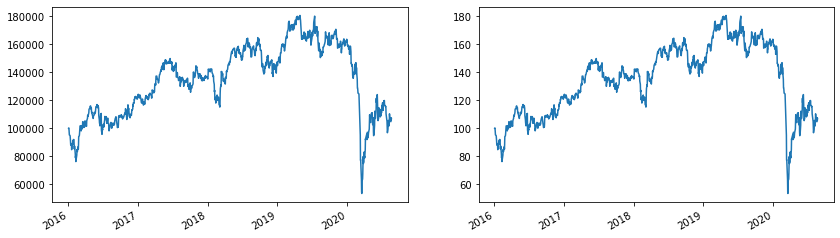

In [19]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))
portvalue.plot(ax=ax1)
nav.plot(ax=ax2)

In [20]:
# serie booleana a partir de convertir a fecha mensual 
# y luego ver las repeditas
month_repeated = stock_series.index.to_period('m').duplicated()
month_repeated 

array([False,  True,  True, ...,  True,  True,  True])

In [21]:
first_month_trade = stock_series[~month_repeated]
first_month_trade.head()

2016-01-04    20.205989
2016-02-01    18.555449
2016-03-01    19.336083
2016-04-01    21.132302
2016-05-02    23.183418
Name: ACS, dtype: float64

In [22]:
cash_flows = pd.Series(0, index=stock_df.index)
cash_flows.iloc[0] = -capital

In [23]:
regular_cash_in = 2000

In [24]:
for idate in first_month_trade.index[1:]:
    # suscripciones. las nuevas participaciones las tendremos de aquí en adelante
    new_units = regular_cash_in/nav.loc[idate]
    inout_units.loc[idate] = new_units
    n_units = inout_units.cumsum()
    
    # inversion del nuevo efectivo
    delta_shares.loc[idate, ticker] = regular_cash_in/stock_series[idate]
    
    # recalculamos la cartera
    posiciones = delta_shares.cumsum()
    asset_value = posiciones * stock_df
    portvalue = asset_value.sum(axis=1)
    nav = portvalue / n_units
    
    # registramos el cashflow
    cash_flows[idate] = -regular_cash_in    

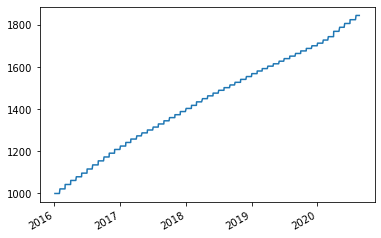

In [25]:
n_units.plot()

In [26]:
portvalue

2016-01-04    100000.000000
2016-01-05    100193.391522
2016-01-06     99419.016308
2016-01-07     96669.458308
2016-01-08     95158.738833
                  ...      
2020-08-17    193098.545696
2020-08-18    193007.289295
2020-08-19    198117.647782
2020-08-20    194741.160924
2020-08-21    197113.827365
Length: 1186, dtype: float64

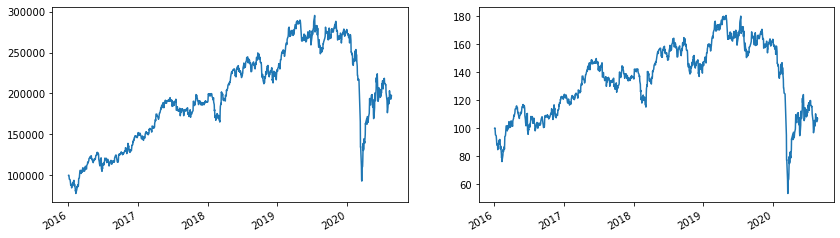

In [27]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))
portvalue.plot(ax=ax1)
nav.plot(ax=ax2)